In [1]:
%matplotlib inline

import numpy as np
import matplotlib.image as mpimg
import os
from sklearn.decomposition import sparse_encode
import matplotlib.pyplot as plt

In [2]:
images = []
folder = "training/groundtruth"
for i in range(100):
    fn = "{}/satImage_".format(folder) + "%.3d" % (i+1) + ".png"
    images.append(mpimg.imread(fn))
images = (np.array(images) > 0.25).astype(np.float32)

In [3]:
images[0].shape

(400, 400)

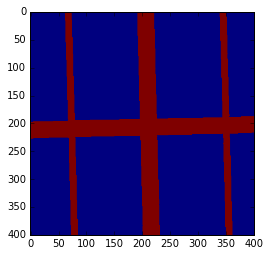

In [4]:
plt.imshow(images[0])

In [5]:
patch_size = 16
superpatch_size = patch_size * 5

In [6]:
def img_to_patches(img, patch_size):
    return np.reshape(img, 
               (-1, img.shape[1] // patch_size, patch_size)
              ).transpose((1, 0, 2)).reshape((-1, patch_size ** 2))

def patches_to_img(patches):
    num_patches, patch_size = map(lambda s: int(np.sqrt(s)), patches.shape)
    return patches.reshape((-1, num_patches * patch_size, patch_size)).transpose((1, 0, 2)).reshape(
        (num_patches * patch_size, num_patches * patch_size))

In [7]:
superpatches = np.array([img_to_patches(i, superpatch_size) for i in images])
superpatches.shape

(100, 25, 6400)

In [8]:
Ut = np.reshape(superpatches, (-1, superpatches.shape[-1]))
Ut.shape

(2500, 6400)

In [9]:
# ATTENTION: Here, we generate targets from the ground truth for demonstration purposes.
# Since we also generate the dictionary from the same ground truth, we can actually only get worse.
# The idea is that you plug in the predictions from your classifier as the targets here
# (replace the "images" variable in the next line).
patches = np.array([img_to_patches(i, patch_size) for i in images]) 
patch_targets = np.tile((np.mean(patches, axis=2) > 0.25).astype(patches.dtype)[:, :, np.newaxis], (1, 1, patch_size ** 2))
patch_targets.shape

(100, 625, 256)

In [10]:
targets = np.array([patches_to_img(i) for i in patch_targets])
targets.shape

(100, 400, 400)

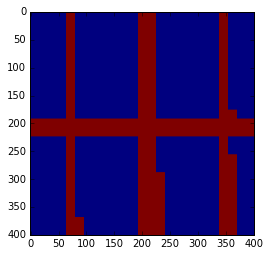

In [14]:
plt.imshow(targets[0])

In [15]:
x = np.reshape([img_to_patches(i, superpatch_size) for i in targets], (-1, superpatch_size ** 2))
x.shape

(2500, 6400)

In [18]:
z = sparse_encode(x, Ut, algorithm='lasso_cd', alpha=100.0, max_iter=1000) #play with these parameters

In [19]:
x_rec = np.dot(z, Ut)
x_rec.shape

(2500, 6400)

In [20]:
imgs_rec = np.array([patches_to_img(i) for i in x_rec.reshape((len(images), -1, superpatch_size ** 2))])
imgs_rec.shape

(100, 400, 400)

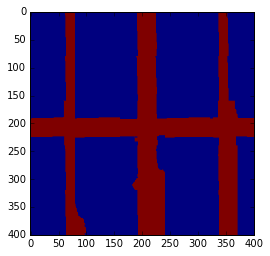

In [21]:
plt.imshow(imgs_rec[0] > 0.25)

In [22]:
pixel_error_pred = np.mean(np.logical_xor(images > 0.25, targets > 0.25))
pixel_error_rec = np.mean(np.logical_xor(images > 0.25, imgs_rec > 0.25))

In [23]:
print("Prediction Error:", pixel_error_pred)
print("Reconstructed Error:", pixel_error_rec)

Prediction Error: 0.0749105625
Reconstructed Error: 0.0828326875


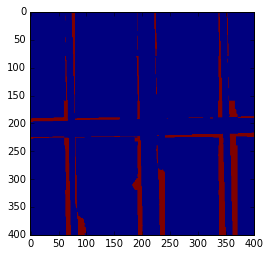

In [24]:
plt.imshow(np.logical_xor(images[0]>0.25, imgs_rec[0]>0.25))